## Project: Sign Language Digit Classification

**Group 4:**\
Darshik Alakkaparambil Somasundaran\
Hamna Ashraf

### Required Libraries:

In [112]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
import seaborn as sns
from tqdm import tqdm


### Get the data:

In [63]:
# Set the path to your data directory
data_dir = "../data/Sign Language for Numbers"

# Set the ratio of data to be used for training (e.g., 80%)
train_ratio = 0.8

# Create directories for train and test data
train_dir = os.path.join("train_test", "train")
test_dir = os.path.join("train_test", "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

## Exploratory Data Analysis (EDA):

**Creating a dataframe:**

In [64]:
image_files = glob.glob("../train_test/train/*/*.jpg")
image_files = [(int(f.split("\\")[1]), f) for f in image_files]
df = pd.DataFrame(image_files, columns=["label", "path"])
df.sample(10)

,label,path
9002,6,../train_test/train\6\six_1363.jpg
12526,8,../train_test/train\8\eight_616.jpg
2998,2,../train_test/train\2\two_1123.jpg
14075,9,../train_test/train\9\nine_714.jpg
7573,5,../train_test/train\5\five_1369.jpg
4122,2,../train_test/train\2\two_821.jpg
12747,8,../train_test/train\8\eight_816.jpg
10959,7,../train_test/train\7\seven_507.jpg
8885,6,../train_test/train\6\six_1253.jpg
11854,8,../train_test/train\8\eight_1344.jpg


This dataframe consists of the labels and path of all images in the training dataset.

**Plotting images of each class before applying data preprocessing and augmentation:** 

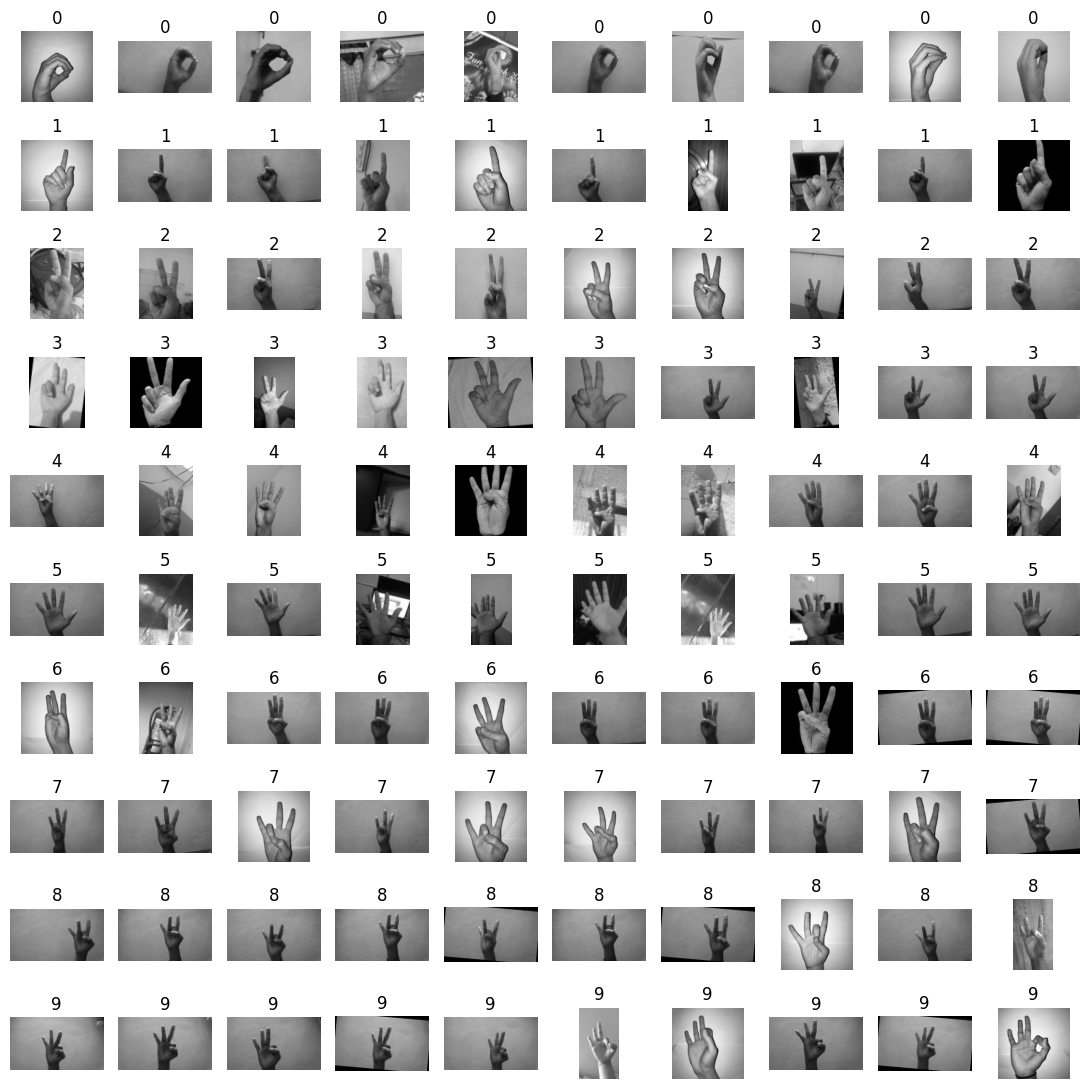

In [109]:
# Initialize an empty dictionary to store digit samples for each class
sign_samples = {}

# Iterate over each digit class (0 to 9)
for i in range(10):
    # Find the indices of training samples belonging to the current digit class
    indices = df[df["label"] == i].index
    # Randomly select 10 samples from the current digit class without replacement
    sign_samples[i] = np.random.choice(indices, 10, replace=False)

plt.figure(figsize=(11,11))

# Iterate over each digit class and its corresponding samples
for i in range(100):
    plt.subplot(10, 10, i + 1)
    # Display the image corresponding to the digit sample
    
    image = cv2.imread(df.loc[sign_samples[i // 10][i % 10],"path"])
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    # Set the title of the subplot to the name of the digit class
    plt.title(df.loc[sign_samples[i // 10][i % 10],"label"])
    plt.axis('off')

plt.tight_layout()
plt.show()

We can see here that the image dimensions vary in all the plot.\
Both *potrait* and *landscape* images are present in the dataset

### Data Preprocessing and Augmentation:

In [82]:
# Set the path to your data directory
train_dir = "../train_test/train"
test_dir = "../train_test/test"

# Set the input size of tge image
input_size = (64, 64)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest',
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 14375 images belonging to 10 classes.
Found 5375 images belonging to 10 classes.


Data augmentation has been applied inorder to create variations in the data so that our model can learn the details of each class and generalize better from training data to unseen data. This will help avoid overfitting.

**Plotting images of each class after applying data preprocessing and augmentation:** 

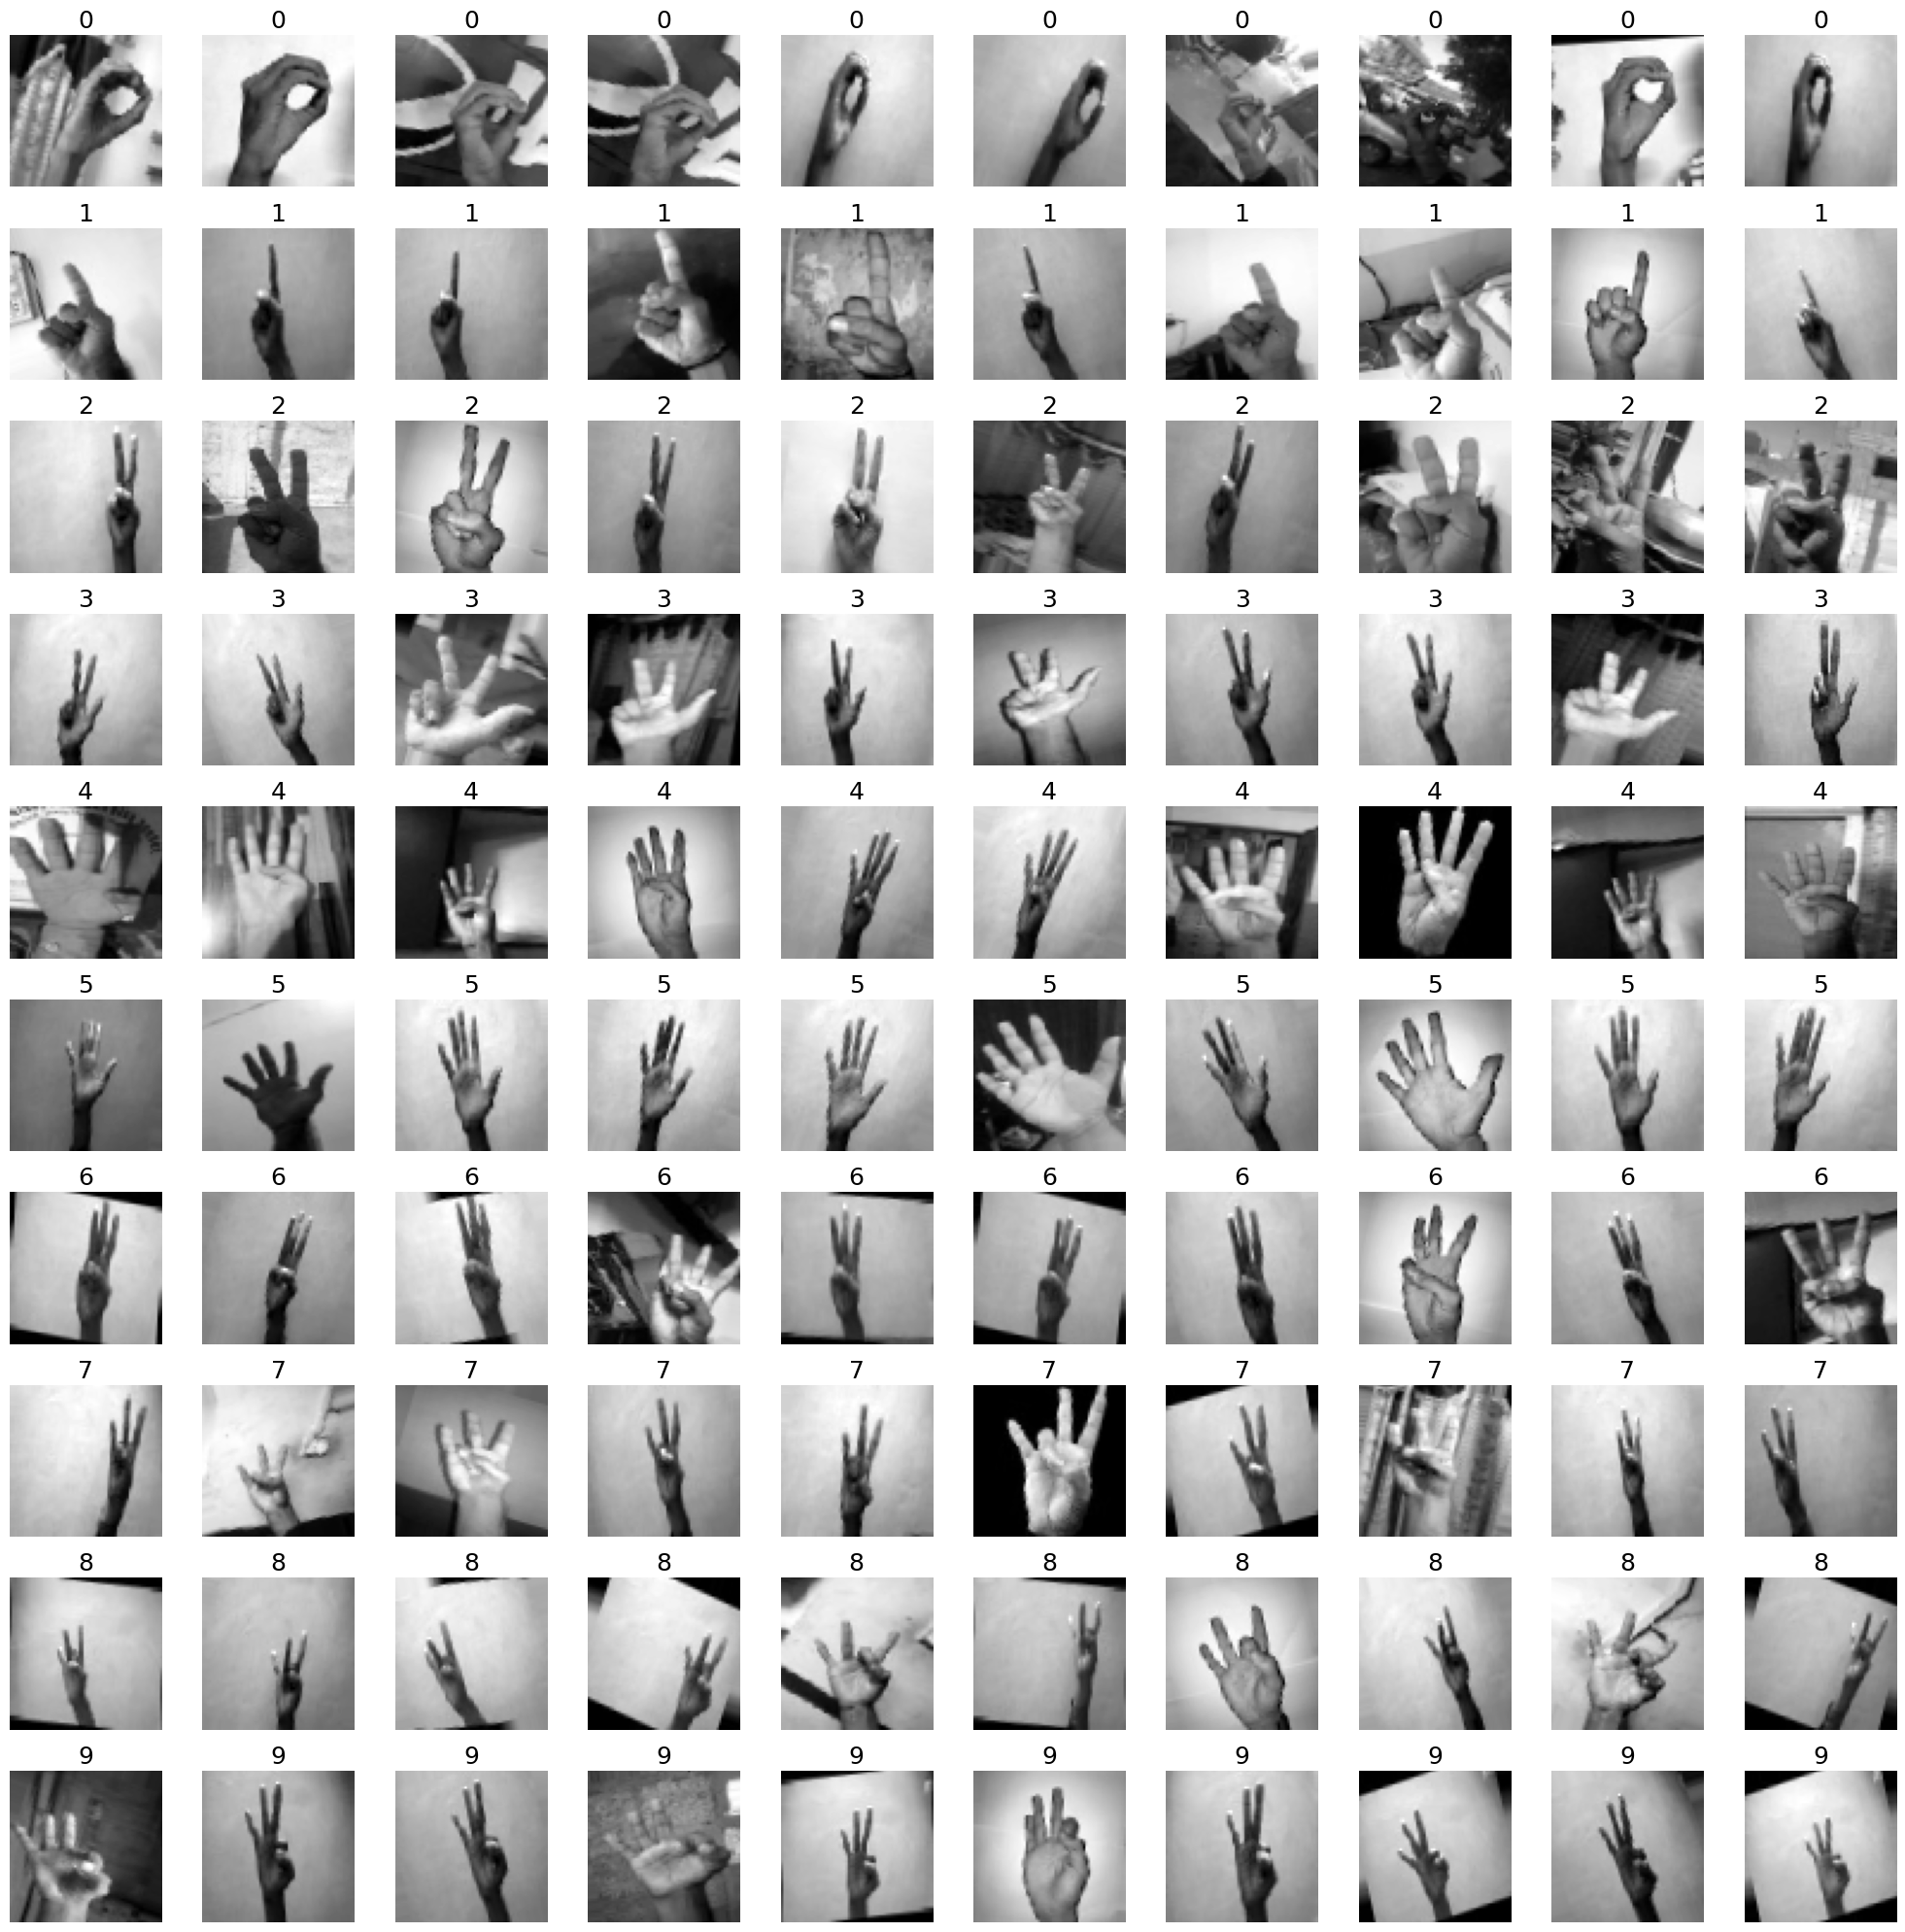

In [83]:
num_images = 10  # Number of images per class to display
class_images = {i: [] for i in range(10)}  # Adjust range if different number of classes

# Iterate through batches to collect images
for _ in range(100):  
    images, labels = next(train_generator)
    class_indices = np.argmax(labels, axis=1)
    
    for img, cls_idx in zip(images, class_indices):
        if len(class_images[cls_idx]) < num_images:
            class_images[cls_idx].append(img)
        # Break the inner loop if all classes have enough images
        if all(len(imgs) >= num_images for imgs in class_images.values()):
            break
    # Break the outer loop if all classes have enough images
    if all(len(imgs) >= num_images for imgs in class_images.values()):
        break

# Set up the figure
fig, axes = plt.subplots(nrows=10, ncols=num_images, figsize=(20, 20))

# Plot each class images in its row
for class_idx, imgs in class_images.items():
    for i, img in enumerate(imgs):
        axes[class_idx, i].imshow(img.reshape(64, 64), cmap='gray')  # Reshape for grayscale
        axes[class_idx, i].set_title(class_idx,  fontsize=18)
        axes[class_idx, i].axis('off')

plt.tight_layout()
plt.show()


The images we can see here are of the same size which is 64 x 64. Not only that but images are in greyscale and rotated too.

In [108]:
print(f"Shape of images:\n{images.shape}\n(batch_size, height, width, channels)")

Shape of images:
(32, 64, 64, 1)
(batch_size, height, width, channels)


**batch_size**: Number of images returned in one batch (as given in train_generator).\
**height**: Height of each image in pixels.\
**width**: Width of each image in pixels.\
**channels**: Number of color channels (1-> greyscale, 3-> RGB).

In [86]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14375 entries, 0 to 14374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   14375 non-null  int64 
 1   path    14375 non-null  object
dtypes: int64(1), object(1)
memory usage: 224.7+ KB
None


Let's check the number of images we have for each digit:

In [85]:
# Function to count files in each subdirectory
def count_files_in_subdirectories(directory):
    label_distribution = {}
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            file_count = len(os.listdir(label_path))
            label_distribution[label] = file_count
    return label_distribution

# Count files in the training directory
train_distribution = count_files_in_subdirectories(train_dir)
test_distribution = count_files_in_subdirectories(test_dir)

# Print out the distributions
print("Training distribution:", train_distribution)
print("Testing distribution:", test_distribution)

Training distribution: {'0': 1432, '1': 1434, '2': 1444, '3': 1427, '4': 1441, '5': 1432, '6': 1437, '7': 1443, '8': 1451, '9': 1434}
Testing distribution: {'0': 532, '1': 534, '2': 544, '3': 527, '4': 541, '5': 532, '6': 537, '7': 543, '8': 551, '9': 534}


**Visual Representation of the images per label:** 

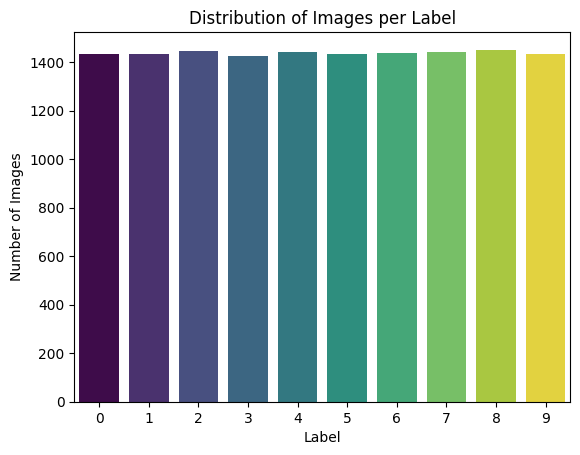

In [88]:
sns.countplot(x= 'label', hue = 'label', data= df, palette="viridis", order=sorted(df['label'].unique()), legend = False)
plt.title("Distribution of Images per Label")
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.show()

This graph shows us that the images we have for each ASL digits (0-9) is **more than 1400**. Which means that the training data is more than 14,000.

In [102]:
print(f"Total training data: {df.shape[0]}")

Total training data: 14375


**Hight and Width Distributions:**

100%|██████████| 14375/14375 [00:03<00:00, 3630.30it/s]


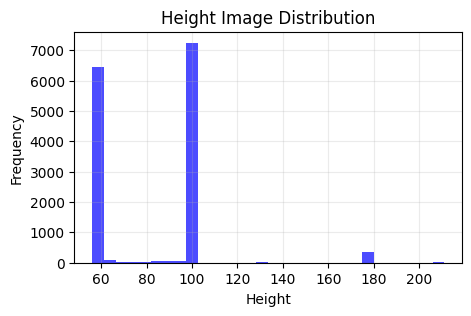

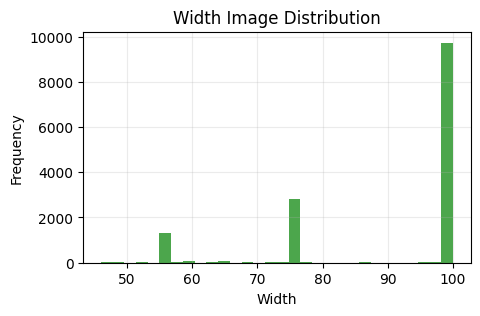

In [114]:
#save heights and widths of images
heights = []
widths = []

# Iterate through each image file path in the DataFrame
for file_path in tqdm(df['path']):
    image = cv2.imread(file_path) 

    height, width, _ = image.shape  
    heights.append(height)
    widths.append(width)
   

# Plot the distribution of heights
plt.figure(figsize=(5, 3))
plt.hist(heights, bins=30, color='blue', alpha=0.7)
plt.title('Height Image Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()

# Plot the distribution of widths
plt.figure(figsize=(5, 3))
plt.hist(widths, bins=30, color='green', alpha=0.7)
plt.title('Width Image Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()

These plot show us that the most images have heights of 60 and 100 whereas most have widths of 100. After the preprocessing step, it was seen that many images seemed to be shrinked. It is because files with more than 64 pixels of width were reshaped to 64.

**Image Stats:**

In [94]:
stats = {str(i): {'means': [], 'std_devs': [], 'mins': [], 'maxes': []} for i in range(10)}

# Iterate through each image in the DataFrame
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_path = row['path']
    label = row['label']
    image = cv2.imread(image_path)

    # Check if the image is loaded properly
    if image is not None:
        # Convert the image to grayscale if it's not already
        if len(image.shape) > 2:
            grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            grayscale_image = image

        # Compute image statistics
        mean_pixel_value = np.mean(grayscale_image)
        std_dev_pixel_value = np.std(grayscale_image)
        min_pixel_value = np.min(grayscale_image)
        max_pixel_value = np.max(grayscale_image)

        # Append image statistics to the respective lists
        stats[str(label)]['means'].append(mean_pixel_value)
        stats[str(label)]['std_devs'].append(std_dev_pixel_value)
        stats[str(label)]['mins'].append(min_pixel_value)
        stats[str(label)]['maxes'].append(max_pixel_value)
    else:
        print(f"Warning: Unable to read image at {image_path}")

# Print overall statistics for each label
for label in stats:
    overall_mean = np.mean(stats[label]['means'])
    overall_std_dev = np.mean(stats[label]['std_devs'])
    overall_min = np.min(stats[label]['mins'])
    overall_max = np.max(stats[label]['maxes'])

    print(f"Label {label}:")
    print("  Overall Mean Pixel Value:", overall_mean)
    print("  Overall Standard Deviation of Pixel Values:", overall_std_dev)
    print("  Overall Minimum Pixel Value:", overall_min)
    print("  Overall Maximum Pixel Value:", overall_max)

100%|██████████| 14375/14375 [00:08<00:00, 1675.64it/s]

Label 0:
  Overall Mean Pixel Value: 123.28777121987113
  Overall Standard Deviation of Pixel Values: 41.553069610571875
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 1:
  Overall Mean Pixel Value: 123.43786028865617
  Overall Standard Deviation of Pixel Values: 41.79297934722957
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 2:
  Overall Mean Pixel Value: 125.83650023415471
  Overall Standard Deviation of Pixel Values: 42.38115342631702
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 3:
  Overall Mean Pixel Value: 125.11493343032234
  Overall Standard Deviation of Pixel Values: 40.33444787591876
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 4:
  Overall Mean Pixel Value: 123.78619496715214
  Overall Standard Deviation of Pixel Values: 41.51207344786768
  Overall Minimum Pixel Value: 0
  Overall Maximum Pixel Value: 255
Label 5:
  Overall Mean Pixel Value: 114.9113470643597
  Ov

In [ ]:
data = {
    'Label': [],
    'Mean Pixel Value': [],
    'Standard Deviation': []
}

for label, metrics in stats.items():
    data['Label'].extend([label] * len(metrics['means']))
    data['Mean Pixel Value'].extend(metrics['means'])
    data['Standard Deviation'].extend(metrics['std_devs'])

df_stats = pd.DataFrame(data)

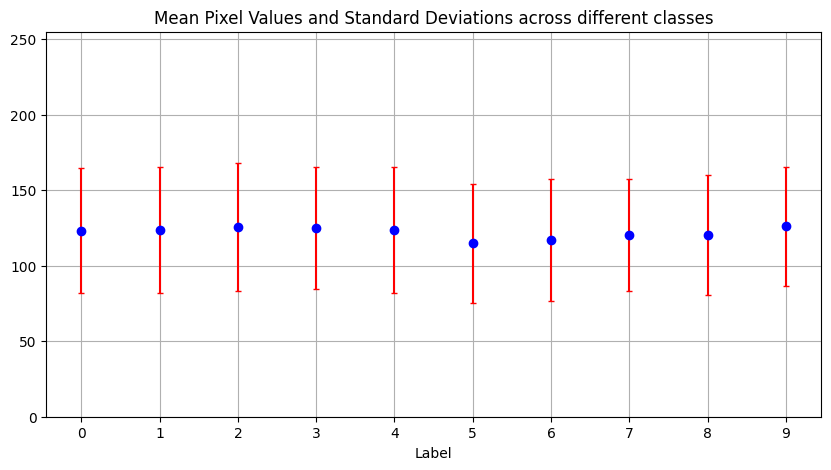

In [111]:
grouped_stats = df_stats.groupby('Label').agg({
    'Mean Pixel Value': 'mean',
    'Standard Deviation': 'mean'
}).reset_index()

labels = grouped_stats['Label']
mean_pixel_values = grouped_stats['Mean Pixel Value']
standard_deviations = grouped_stats['Standard Deviation']

# Converting labels to a numeric format for plotting
numeric_labels = np.arange(len(labels))

plt.figure(figsize=(10, 5))
plt.errorbar(numeric_labels, mean_pixel_values, yerr=standard_deviations, fmt='o', color='blue', ecolor='red', capsize=2)
plt.xticks(numeric_labels, labels)  # Set text labels for the x-axis
plt.title('Mean Pixel Values and Standard Deviations across different classes')
plt.xlabel('Label')
plt.ylim(0,255)
plt.grid(True)
plt.show()

Blue dot -> overall mean pixel value for each label\
Red line -> overall standard deviation of pixel value for each label

The image statistics and this plot shows us that the mean of pixel values against each label is in range 110 - 130. And the standard deviation ranges from 35 - 45. It shows us that the all images for digits have similar statistics in terms of pixel values.

## **Model Selection and Training**

Required libraries for model training:

In [ ]:
# Import necessary libraries
import warnings  # For filtering warnings
from keras.models import Sequential  # For building sequential models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout  # Different layers for building the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # Callbacks for model training
from keras.optimizers import Adam, RMSprop  # Optimizers for training the model
import keras_tuner  # For hyperparameter tuning
from tensorflow.keras.applications import MobileNet  # Pre-trained MobileNet model
from tensorflow.keras.regularizers import l2  # L2 regularization for the model

# Filter warnings to ignore them during runtime
warnings.filterwarnings("ignore")

#### **Vanilla CNN - Hyperparameter Tuning**

In [119]:

# Set the path to your data directory
train_dir = "train_test/train"
test_dir = "train_test/test"

# Data augmentation and preprocessing
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Provide the path to your dataset
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color mode to RGB
    subset='training'  # Specify training subset
)

# Validation data generator using the same ImageDataGenerator
validation_generator = data_generator.flow_from_directory(
    train_dir,  # Same directory as training data
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color mode to RGB
    subset='validation'  # Specify validation subset
)

Found 9600 images belonging to 10 classes.
Found 2400 images belonging to 10 classes.


In [120]:
# Define the function to create the model
def create_model(hp):
    
    # Create a Sequential model
    model = Sequential()
    
    # Add Convolutional layers with variable number of filters chosen from the hyperparameter 'filters1', 'filters2', 'filters3'
    model.add(Conv2D(hp.Choice('filters1', [16, 32]), (2,2), input_shape=(64, 64, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(hp.Choice('filters2', [32, 64]), (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
    model.add(Conv2D(hp.Choice('filters3', [64, 128]), (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(5,5), padding='same'))
    
    # Flatten layer to transition from convolutional to fully connected layers
    model.add(Flatten())
    
    # Add Dense layers with variable number of units chosen from the hyperparameter 'n_units'
    model.add(Dense(hp.Choice('n_units', [128, 256]), activation='relu'))
    
    # Dropout layer to prevent overfitting
    model.add(Dropout(0.2))
    
    # Output layer with 10 units for multi-class classification
    model.add(Dense(10, activation='softmax'))
    
    # Choose optimizer from 'adam' or 'rmsprop' based on the hyperparameter 'optimizer'
    optimizer = hp.Choice('optimizer', ["adam", "rmsprop"])
    if optimizer == 'adam': opt = Adam()
    else: opt = RMSprop()
    
    # Compile the model with categorical crossentropy loss and the chosen optimizer
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Return the compiled model
    return model

In [121]:
# Initialize a RandomSearch tuner from the keras_tuner module
tuner = keras_tuner.RandomSearch(
    create_model,  # The function to create the model
    objective='val_loss',  # The metric to optimize (minimize)
    max_trials=5  # The maximum number of hyperparameter combinations to try
)

Reloading Tuner from .\untitled_project\tuner0.json


In [122]:
# Initialize empty lists to store batches of samples from the train and validation generators
train_batch_x = []  # List to store input features from the train generator
train_batch_y = []  # List to store labels from the train generator
valid_batch_x = []  # List to store input features from the validation generator
valid_batch_y = []  # List to store labels from the validation generator

# Iterate over batches of samples from the train generator
for i in tqdm.tqdm(range(len(train_generator))):
    # Get a batch of samples from the train generator
    batch = train_generator.__getitem__(i)
    # Append input features and labels to the respective lists
    train_batch_x.append(batch[0])
    train_batch_y.append(batch[1])

# Iterate over batches of samples from the validation generator
for i in tqdm.tqdm(range(len(validation_generator))):
    # Get a batch of samples from the validation generator
    batch = validation_generator.__getitem__(i)
    # Append input features and labels to the respective lists
    valid_batch_x.append(batch[0])
    valid_batch_y.append(batch[1])

100%|██████████| 38/38 [00:01<00:00, 32.26it/s]


In [123]:
# Select a subset of samples from the training set for hyperparameter tuning
X_train_sample = np.array(train_batch_x[:-1]).reshape(-1, 64, 64, 1)[::5]  # Extract input features and reshape
y_train_sample = np.array(train_batch_y[:-1]).reshape(-1, 10)[::5]  # Extract labels and reshape
print(X_train_sample.shape, y_train_sample.shape)  # Print the shape of the selected training samples

# Select a subset of samples from the validation set for hyperparameter tuning
X_valid_sample = np.array(valid_batch_x[:-1]).reshape(-1, 64, 64, 1)[::5]  # Extract input features and reshape
y_valid_sample = np.array(valid_batch_y[:-1]).reshape(-1, 10)[::5]  # Extract labels and reshape
print(X_valid_sample.shape, y_valid_sample.shape)  # Print the shape of the selected validation samples

(1908, 64, 64, 1) (1908, 10)
(474, 64, 64, 1) (474, 10)


In [124]:
# Perform hyperparameter tuning using the RandomSearch tuner
tuner.search(
    X_train_sample,  # Input features of the training samples
    y_train_sample,  # Labels of the training samples
    epochs=10,  # Number of epochs for training
    validation_data=(X_valid_sample, y_valid_sample)  # Validation data for model evaluation
)

In [125]:
# Create a model using the best hyperparameters found by the tuner
model1 = create_model(tuner.get_best_hyperparameters(1)[0])

# Print the summary of the created model
model1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 63, 63, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 6, 6, 128)      │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,146 (941.98 KB)

 Trainable params: 241,146 (941.98 KB)

 Non-trainable params: 0 (0.00 B)

#### **Vanilla CNN - Training**

In [126]:
# Define EarlyStopping callback to stop training if validation loss stops improving
early_stoping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,  # Minimum change in validation loss to be considered an improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights to the best observed during training
    verbose=0  # Set to 1 for verbose output
)

# Define ReduceLROnPlateau callback to adjust learning rate if validation accuracy plateaus
reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,  # Factor by which the learning rate will be reduced
    verbose=1  # Set to 1 for verbose output
)

# Define ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'checkpoints/vanilla/checkpoint.keras',  # Path to save the checkpoint
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model based on the monitored quantity
    mode='min',  # Set to 'min' to save the model with the minimum monitored quantity (validation loss)
    verbose=1  # Set to 1 for verbose output
)

In [127]:
# Train the model (model1) using fit method
history_model1 = model1.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=50,  # Number of epochs for training
    callbacks=[early_stoping, reduce_learning_rate, checkpoint],  # List of callbacks for monitoring and adjustments during training
    verbose=1  # Set to 1 for verbose output during training
)

Epoch 1/50
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0979 - loss: 2.3023
Epoch 1: val_loss improved from inf to 2.36695, saving model to checkpoints/vanilla/checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.0982 - loss: 2.3021 - val_accuracy: 0.0996 - val_loss: 2.3670 - learning_rate: 0.0010
Epoch 2/50
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1998 - loss: 2.1583
Epoch 2: val_loss improved from 2.36695 to 2.19522, saving model to checkpoints/vanilla/checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.2001 - loss: 2.1577 - val_accuracy: 0.2125 - val_loss: 2.1952 - learning_rate: 0.0010
Epoch 3/50
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3358 - loss: 1.8735
Epoch 3: val_loss improved from 2.19522 to 1.77147, saving model to checkpoints/vanilla/checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.3362 - loss: 1.8721 - val_accuracy: 0.3854 - val_loss: 1.7715 - learning_rate: 0.0010
Ep

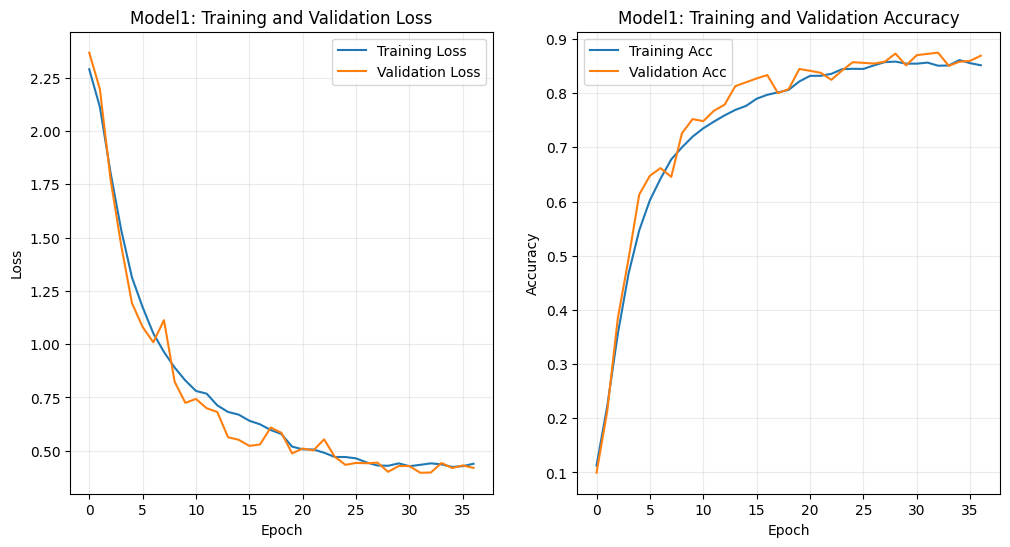

In [128]:
train_loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']
train_acc = history_model1.history['accuracy']
val_acc = history_model1.history['val_accuracy']

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model1: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.25)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Model1: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.25)

#### **MobileNet - Training Top Layer**

In [129]:
# Set the path to your data directory
train_dir = "train_test/train"
test_dir = "train_test/test"

# Data augmentation and preprocessing
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Provide the path to your dataset
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',  # Set color mode to RGB
    subset='training'  # Specify training subset
)

# Validation data generator using the same ImageDataGenerator
validation_generator = data_generator.flow_from_directory(
    train_dir,  # Same directory as training data
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',  # Set color mode to RGB
    subset='validation'  # Specify validation subset
)

Found 9600 images belonging to 10 classes.
Found 2400 images belonging to 10 classes.


In [130]:
# Load MobileNet model pretrained on ImageNet dataset
base_model = MobileNet(
    weights='imagenet',  # Use pre-trained weights from ImageNet
    include_top=False,  # Exclude the fully connected layers at the top
    input_shape=(64, 64, 3),  # Input shape of the images (64x64 pixels with 3 channels)
    alpha=1.0  # Width multiplier for the MobileNet architecture
)

# Add custom top layers for classification on top of the MobileNet base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer to reduce spatial dimensions
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with ReLU activation and L2 regularization
predictions = Dense(10, activation='softmax')(x)  # Output layer with softmax activation for 10 classes

# Create the model by specifying input and output layers
model2 = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers of the MobileNet base if needed
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [131]:
# Define EarlyStopping callback to stop training if validation loss stops improving
early_stoping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,  # Minimum change in validation loss to be considered an improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights to the best observed during training
    verbose=0  # Set to 1 for verbose output
)

# Define ReduceLROnPlateau callback to adjust learning rate if validation accuracy plateaus
reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,  # Factor by which the learning rate will be reduced
    verbose=1  # Set to 1 for verbose output
)

# Define ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'checkpoints/mobilenet/checkpoint.keras',  # Path to save the checkpoint
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model based on the monitored quantity
    mode='min',  # Set to 'min' to save the model with the minimum monitored quantity (validation loss)
    verbose=1  # Set to 1 for verbose output
)

In [132]:
# Train the model with frozen base layers for 2 epochs
history_model2 = model2.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=2,  # Number of epochs for training
    callbacks=[early_stoping, reduce_learning_rate, checkpoint],  # List of callbacks for monitoring and adjustments during training
    verbose=1  # Set to 1 for verbose output during training
)

Epoch 1/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3929 - loss: 2.1912
Epoch 1: val_loss improved from inf to 1.60354, saving model to checkpoints/mobilenet/checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.3936 - loss: 2.1891 - val_accuracy: 0.5633 - val_loss: 1.6035 - learning_rate: 0.0010
Epoch 2/2
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6129 - loss: 1.4757
Epoch 2: val_loss improved from 1.60354 to 1.47289, saving model to checkpoints/mobilenet/checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.6130 - loss: 1.4752 - val_accuracy: 0.5904 - val_loss: 1.4729 - learning_rate: 0.0010


#### **MobileNet - Fine-Tuning All Layers**

In [133]:
# Set all layers of the base model to be trainable for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model after fine-tuning
model2.compile(
    optimizer=Adam(),  # Optimizer for training
    loss='categorical_crossentropy',  # Loss function for optimization
    metrics=['accuracy']  # Metrics to monitor during training
)

In [134]:
# Fine-tune the model with trainable base layers
history_model2_ = model2.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=50,  # Number of epochs for fine-tuning
    callbacks=[early_stoping, reduce_learning_rate, checkpoint],  # List of callbacks for monitoring and adjustments during training
    verbose=1  # Set to 1 for verbose output during training
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5278 - loss: 1.8289
Epoch 1: val_loss did not improve from 1.47289
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.5286 - loss: 1.8256 - val_accuracy: 0.4625 - val_loss: 3.1383 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8246 - loss: 0.7861
Epoch 2: val_loss improved from 1.47289 to 1.24590, saving model to checkpoints/mobilenet/checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.8246 - loss: 0.7859 - val_accuracy: 0.6783 - val_loss: 1.2459 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8754 - loss: 0.5826
Epoch 3: val_loss improved from 1.24590 to 1.00904, saving model to checkpoints/mobilenet/checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.8755 - loss: 0.5824 - val_accuracy: 0.7708 - val_loss: 1.0090 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 

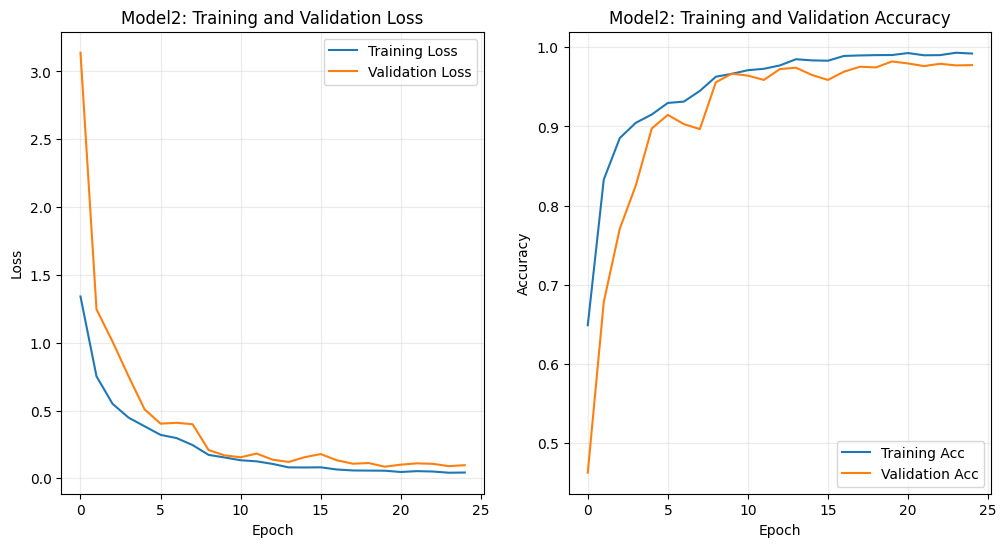

In [135]:
train_loss = history_model2_.history['loss']
val_loss = history_model2_.history['val_loss']
train_acc = history_model2_.history['accuracy']
val_acc = history_model2_.history['val_accuracy']

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model2: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.25)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Model2: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.25)

## **Model Evaluation**

In [162]:
from keras.models import load_model  # For loading pre-trained models
from sklearn.metrics import confusion_matrix

#### **Vanilla CNN - Testing**

In [177]:
# Set the path to your data directory
test_dir = "train_test/test"

# Data augmentation and preprocessing
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
)

# Provide the path to your dataset
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',  # Set color mode to RGB
)

Found 3000 images belonging to 10 classes.


In [178]:
# Load the best model checkpoints
best_model1 = load_model("checkpoints/vanilla/checkpoint.keras")

# Compile the model with additional metrics
best_model1.compile(
    optimizer=Adam(),  # Optimizer for training
    loss='categorical_crossentropy',  # Loss function for optimization
    metrics=['accuracy', 'precision', 'recall', 'f1_score']  # Metrics to monitor during training
)

In [179]:
# Evaluate the model
loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []
counter = 0

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Wrap the test generator with tqdm for progress visualization
for test_data, test_labels in tqdm.tqdm(test_generator):
    
    if counter == len(test_generator):
        break
    
    predictions = best_model1.predict(test_data)
    
    # Convert one-hot encoded labels to class indices
    true_labels_batch = np.argmax(test_labels, axis=1)
    predicted_labels_batch = np.argmax(predictions, axis=1)
    
    # Append true labels and predicted labels for the current batch to the lists
    true_labels.extend(true_labels_batch)
    predicted_labels.extend(predicted_labels_batch)
    
    # Compute metrics for the current batch
    loss, accuracy, precision, recall, f1_score = best_model1.evaluate(test_data, test_labels, verbose=0)
    
    # Append metrics for the current batch to lists
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_score_values.append(f1_score)
    counter += 1

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute the average metrics over all batches
avg_loss = np.mean(loss_values)
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1_score = np.mean(f1_score_values)

print('\nAverage Loss      :', round(avg_loss, 4))
print('Average Accuracy  :', round(avg_accuracy, 4))
print('Average Precision :', round(avg_precision, 4))
print('Average Recall    :', round(avg_recall, 4))
print('Average F1 Score  :', round(avg_f1_score, 4))
# Print the overall confusion matrix
print("\nOverall Confusion Matrix:\n")
print(conf_matrix)

  0%|          | 0/47 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  2%|▏         | 1/47 [00:01<00:47,  1.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  4%|▍         | 2/47 [00:01<00:24,  1.82it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  6%|▋         | 3/47 [00:01<00:17,  2.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▊         | 4/47 [00:01<00:13,  3.08it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 11%|█         | 5/47 [00:02<00:13,  3.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 13%|█▎        | 6/47 [00:02<00:12,  3.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 15%|█▍        | 7/47 [00:02<00:10,  3.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 17%|█▋        | 8/47 [00:02<00:10,  3.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 19%|█▉        | 9/47 [00:02<00:09,  3.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 21%|██▏       | 10/47 [00:03<00:09,  4.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██▎       | 11/47 [00:03<00:08,  4.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▌       | 12/47 [00:03<00:07,  4.83it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 28%|██▊       | 13/47 [00:03<00:06,  5.02it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 30%|██▉       | 14/47 [00:03<00:06,  5.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 32%|███▏      | 15/47 [00:04<00:05,  5.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 34%|███▍      | 16/47 [00:04<00:05,  5.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 36%|███▌      | 17/47 [00:04<00:05,  5.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 38%|███▊      | 18/47 [00:04<00:05,  5.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|████      | 19/47 [00:04<00:04,  5.64it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 43%|████▎     | 20/47 [00:04<00:04,  5.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 45%|████▍     | 21/47 [00:05<00:04,  5.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 47%|████▋     | 22/47 [00:05<00:04,  5.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|████▉     | 23/47 [00:05<00:04,  5.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 24/47 [00:05<00:04,  5.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 25/47 [00:05<00:04,  5.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 55%|█████▌    | 26/47 [00:06<00:03,  5.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 57%|█████▋    | 27/47 [00:06<00:03,  5.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 60%|█████▉    | 28/47 [00:06<00:03,  5.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 62%|██████▏   | 29/47 [00:06<00:03,  5.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 64%|██████▍   | 30/47 [00:06<00:03,  5.04it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 66%|██████▌   | 31/47 [00:06<00:03,  5.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████▊   | 32/47 [00:07<00:02,  5.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 70%|███████   | 33/47 [00:07<00:02,  5.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 72%|███████▏  | 34/47 [00:07<00:02,  5.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 74%|███████▍  | 35/47 [00:07<00:02,  4.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 77%|███████▋  | 36/47 [00:08<00:02,  4.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 79%|███████▊  | 37/47 [00:08<00:02,  4.52it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 81%|████████  | 38/47 [00:08<00:01,  4.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 39/47 [00:08<00:01,  4.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 85%|████████▌ | 40/47 [00:08<00:01,  4.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 87%|████████▋ | 41/47 [00:09<00:01,  4.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 89%|████████▉ | 42/47 [00:09<00:01,  4.53it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 91%|█████████▏| 43/47 [00:09<00:00,  4.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 94%|█████████▎| 44/47 [00:09<00:00,  4.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 96%|█████████▌| 45/47 [00:10<00:00,  4.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


 98%|█████████▊| 46/47 [00:10<00:00,  4.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|██████████| 47/47 [00:11<00:00,  4.27it/s]


Average Loss      : 0.2789
Average Accuracy  : 0.912
Average Precision : 0.9422
Average Recall    : 0.895
Average F1 Score  : 0.9048

Overall Confusion Matrix:

[[293   0   1   0   2   1   3   0   0   0]
 [  5 281   5   1   1   0   4   0   1   2]
 [  1  11 259   4   3   0  13   8   0   1]
 [  0   0   1 275   2   3   0   2   1  16]
 [  1   0   3   0 260   4  28   1   0   3]
 [  0   0   0   0   0 300   0   0   0   0]
 [  1   0  10   3  20   0 261   5   0   0]
 [  0   1   4   2  13   0   7 266   6   1]
 [  4   4   2   3   1   2   3   9 258  14]
 [  0   1   2   0   5   4   0   2   3 283]]


#### **MobileNet - Testing**

In [168]:
# Set the path to your data directory
test_dir = "train_test/test"

# Data augmentation and preprocessing
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
)

# Provide the path to your dataset
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',  # Set color mode to RGB
)

Found 3000 images belonging to 10 classes.


In [169]:
# Load the best model checkpoints
best_model2 = load_model("checkpoints/mobilenet/checkpoint.keras")

# Compile the model with additional metrics
best_model2.compile(
    optimizer=Adam(),  # Optimizer for training
    loss='categorical_crossentropy',  # Loss function for optimization
    metrics=['accuracy', 'precision', 'recall', 'f1_score']  # Metrics to monitor during training
)

In [173]:
# Evaluate the model
loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []
counter = 0

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Wrap the test generator with tqdm for progress visualization
for test_data, test_labels in tqdm.tqdm(test_generator):
    
    if counter == len(test_generator):
        break
    
    predictions = best_model2.predict(test_data)
    
    # Convert one-hot encoded labels to class indices
    true_labels_batch = np.argmax(test_labels, axis=1)
    predicted_labels_batch = np.argmax(predictions, axis=1)
    
    # Append true labels and predicted labels for the current batch to the lists
    true_labels.extend(true_labels_batch)
    predicted_labels.extend(predicted_labels_batch)
    
    # Compute metrics for the current batch
    loss, accuracy, precision, recall, f1_score = best_model2.evaluate(test_data, test_labels, verbose=0)
    
    # Append metrics for the current batch to lists
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_score_values.append(f1_score)
    counter += 1

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute the average metrics over all batches
avg_loss = np.mean(loss_values)
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1_score = np.mean(f1_score_values)

print('\nAverage Loss      :', round(avg_loss, 4))
print('Average Accuracy  :', round(avg_accuracy, 4))
print('Average Precision :', round(avg_precision, 4))
print('Average Recall    :', round(avg_recall, 4))
print('Average F1 Score  :', round(avg_f1_score, 4))
# Print the overall confusion matrix
print("\nOverall Confusion Matrix:\n")
print(conf_matrix)

  0%|          | 0/47 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 1/47 [00:00<00:14,  3.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▍         | 2/47 [00:00<00:15,  2.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▋         | 3/47 [00:01<00:15,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  9%|▊         | 4/47 [00:01<00:16,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|█         | 5/47 [00:01<00:16,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 13%|█▎        | 6/47 [00:02<00:16,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 7/47 [00:02<00:15,  2.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 8/47 [00:03<00:15,  2.56it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 9/47 [00:03<00:14,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 21%|██▏       | 10/47 [00:03<00:14,  2.55it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 11/47 [00:04<00:14,  2.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 12/47 [00:04<00:13,  2.58it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██▊       | 13/47 [00:04<00:12,  2.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|██▉       | 14/47 [00:05<00:12,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|███▏      | 15/47 [00:05<00:12,  2.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 34%|███▍      | 16/47 [00:06<00:11,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 17/47 [00:06<00:11,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 18/47 [00:06<00:10,  2.71it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 19/47 [00:07<00:10,  2.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 20/47 [00:07<00:09,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▍     | 21/47 [00:07<00:09,  2.61it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 22/47 [00:08<00:09,  2.74it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 23/47 [00:08<00:08,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 24/47 [00:09<00:08,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 53%|█████▎    | 25/47 [00:09<00:08,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 26/47 [00:09<00:07,  2.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 27/47 [00:10<00:07,  2.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 28/47 [00:10<00:07,  2.68it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████▏   | 29/47 [00:10<00:06,  2.66it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 30/47 [00:11<00:06,  2.72it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 31/47 [00:11<00:05,  2.77it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 32/47 [00:11<00:05,  2.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████   | 33/47 [00:12<00:04,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 34/47 [00:12<00:04,  2.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 35/47 [00:12<00:04,  2.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 36/47 [00:13<00:03,  2.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▊  | 37/47 [00:13<00:03,  2.95it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 38/47 [00:14<00:03,  2.87it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 39/47 [00:14<00:02,  2.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▌ | 40/47 [00:14<00:02,  2.79it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 41/47 [00:15<00:02,  2.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 42/47 [00:15<00:01,  2.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████▏| 43/47 [00:15<00:01,  2.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 44/47 [00:16<00:01,  2.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▌| 45/47 [00:16<00:00,  2.96it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 46/47 [00:16<00:00,  2.89it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


100%|██████████| 47/47 [00:17<00:00,  2.73it/s]


Average Loss      : 0.0476
Average Accuracy  : 0.993
Average Precision : 0.994
Average Recall    : 0.9916
Average F1 Score  : 0.9899

Overall Confusion Matrix:

[[290   0   0   0   0   0   0   0   0   0]
 [  0 291   0   0   0   0   0   0   0   0]
 [  0   0 297   0   0   0   2   0   0   0]
 [  0   0   0 296   0   0   0   0   0   1]
 [  0   0   0   0 301   0   0   3   0   0]
 [  0   0   0   0   0 299   0   0   0   0]
 [  0   0   0   1   0   1 304   1   0   0]
 [  0   0   1   1   0   0   1 298   2   0]
 [  1   1   0   0   0   0   0   2 304   2]
 [  0   0   0   0   0   0   1   0   0 299]]
